<a href="https://colab.research.google.com/github/kristinanett/02456-deep-learning-with-PyTorch/blob/master/4_Convolutional/4.3-EXE-CIFAR-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credits

This is heavily influenced from https://github.com/pytorch/tutorials

# CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


In order to train a classifier the following steps needs to be performed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

We will help you along the way.
We indicate the places you need to modify the code with `# Your code here!`.
It is however a good idea to read the entire assignment before you begin coding!

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]

**NB** Modify the code below to only use a small part of the dataset if your computer is very slow.

In [28]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = False
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.targets = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.targets = new_test_labels

    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
used classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [29]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.targets)))


print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(testloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.targets)))

# Training data
Number of points: 50000
Batch dimension [B x C x H x W]: torch.Size([4, 3, 32, 32])
Number of distinct labels: 10

# Test data
Number of points: 10000
Batch dimension [B x C x H x W]: torch.Size([4, 3, 32, 32])
Number of distinct labels: 10


Let us show some of the training images, for fun.



horse   cat truck plane


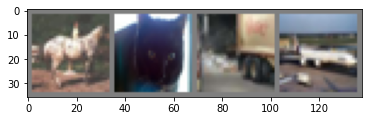

In [30]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [31]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

num_l1 = 300
num_l2 = 300
channels = 3
height = 32
width = 32

#define convolutional layer parameters
num_filters_conv1 = 16
kernel_size_conv1 = 5
stride_conv1 = 1
padding_conv1 = 2

#define second convolutional layer parameters
num_filters_conv2 = 32


def compute_conv_dim(dim_size):
    return int((dim_size - kernel_size_conv1 + 2 * padding_conv1) / stride_conv1 + 1)

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        
        # Your code here!
        self.conv_1 = nn.Conv2d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1,
                             padding=padding_conv1)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1_out_height = compute_conv_dim(height)
        self.conv1_out_width = compute_conv_dim(width)

        self.conv_2 = nn.Conv2d(in_channels=num_filters_conv1,
                             out_channels=num_filters_conv2,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1,
                             padding=padding_conv1)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_3 = nn.Conv2d(in_channels=num_filters_conv2,
                             out_channels=num_filters_conv2,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1,
                             padding=padding_conv1)

        #calculate nr of features that go into the fully connected layer
        self.l1_in_features = num_filters_conv2 * int(self.conv1_out_height/4) * int(self.conv1_out_width/4)    
        
        self.l_1 = nn.Linear(in_features=self.l1_in_features, 
                          out_features=num_l1,
                          bias=True)
        
        self.l_2 = nn.Linear(in_features=num_l1, 
                          out_features=num_l2,
                          bias=True)
        
        self.l_out = nn.Linear(in_features=num_l2, 
                            out_features=self.num_classes,
                            bias=False)
        
        
        # adding dropout to the network
        self.dropout = nn.Dropout2d(p=0.5)

        

    def forward(self, x):
        # Your code here!

        #convolutional + pooling layer
        x = self.pool1(self.conv_1(x))
        x = F.relu(x)

        #second convolutional + pooling layer
        x = self.pool2(self.conv_2(x))
        x = F.relu(x)

        #third convolutional layer
        x = self.conv_3(x)
        x = F.relu(x)

        #fully connected layer
        x = x.view(-1, self.l1_in_features)
        x = F.relu(self.dropout(self.l_1(x)))

        #second fully connected layer
        x = F.relu(self.dropout(self.l_2(x)))

        return self.l_out(x) 
    

net = Net(len(used_categories))

if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()

print(net)

##converting network to cuda-enabled
Net(
  (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (l_1): Linear(in_features=2048, out_features=300, bias=True)
  (l_2): Linear(in_features=300, out_features=300, bias=True)
  (l_out): Linear(in_features=300, out_features=10, bias=False)
  (dropout): Dropout2d(p=0.5, inplace=False)
)


## 3. Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [32]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # Your code here!
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # Your code here!

## 4. Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [33]:
num_epoch = 15  # Your code here!

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    net.train()

    for i, data in enumerate(trainloader, 0):
        # get the inputs 
        inputs, labels = data #data is a list of [inputs, labels]

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        if torch.cuda.is_available():
          inputs, labels = inputs.cuda(), labels.cuda()


        # zero the parameter gradients
        # Your code here!
        optimizer.zero_grad()

        # forward + backward + optimize
        # Your code here!
        output = net(inputs)

        # compute gradients given loss
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
  
        # print statistics
        running_loss += loss.item() #loss.data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 2.302
[1,  2000] loss: 2.247
[1,  3000] loss: 2.066
[1,  4000] loss: 1.914
[1,  5000] loss: 1.838
[1,  6000] loss: 1.773
[1,  7000] loss: 1.680
[1,  8000] loss: 1.624
[1,  9000] loss: 1.594
[1, 10000] loss: 1.504
[1, 11000] loss: 1.465
[1, 12000] loss: 1.480
[2,  1000] loss: 1.398
[2,  2000] loss: 1.388
[2,  3000] loss: 1.331
[2,  4000] loss: 1.347
[2,  5000] loss: 1.295
[2,  6000] loss: 1.306
[2,  7000] loss: 1.290
[2,  8000] loss: 1.266
[2,  9000] loss: 1.244
[2, 10000] loss: 1.263
[2, 11000] loss: 1.216
[2, 12000] loss: 1.187
[3,  1000] loss: 1.129
[3,  2000] loss: 1.135
[3,  3000] loss: 1.115
[3,  4000] loss: 1.117
[3,  5000] loss: 1.128
[3,  6000] loss: 1.109
[3,  7000] loss: 1.101
[3,  8000] loss: 1.062
[3,  9000] loss: 1.105
[3, 10000] loss: 1.048
[3, 11000] loss: 1.088
[3, 12000] loss: 1.061
[4,  1000] loss: 0.995
[4,  2000] loss: 0.988
[4,  3000] loss: 0.934
[4,  4000] loss: 0.997
[4,  5000] loss: 0.967
[4,  6000] loss: 0.960
[4,  7000] loss: 0.992
[4,  8000] 

## 5. Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

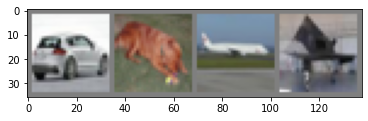

GroundTruth:     car   dog plane plane
Predicted:       car  frog plane plane


In [34]:
net.eval()
images, labels = test_data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

if torch.cuda.is_available():
  images = images.cuda()
outputs = net(images)
_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [35]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    if torch.cuda.is_available():
      images, labels = images.cuda(), labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    testset.data.shape[0], 100 * correct.true_divide(total)))

Accuracy of the network on the 10000 test images: 71.20 %


Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).


We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [36]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    if torch.cuda.is_available():
      images, labels = images.cuda(), labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i].cpu().numpy()
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 82.00 %
Accuracy of car   : 87.00 %
Accuracy of bird  : 60.30 %
Accuracy of cat   : 58.90 %
Accuracy of deer  : 59.70 %
Accuracy of dog   : 51.40 %
Accuracy of frog  : 79.90 %
Accuracy of horse : 79.50 %
Accuracy of ship  : 74.00 %
Accuracy of truck : 79.30 %


**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

3. Write down key lessons/insights you got (if any) during this exercise.

**Answer:**

Expariment description:

- First test was with a network of 1 convolutional layer and 1 fully connected layer. The test accuracy was 9.73 % (maybe something went wrong here)

- A pooling layer was added after the convolutional resulting in test accuracy: 51.76 %

- Adding dropout to the convolutional layer and adding a second fully connected layer also with dropout, accuracy: 45.39 %

- Removing both dropouts and changing the learning rate (0.001) and momentum (0.9), test accuracy: 47.25 %

- Removing the softmax function from the end of the network, test accuracy: 64.11 %

- Added dropout to the convolutional layer again, test accuracy: 56.98 %

- Add a second convolutional layer (no pooling for that), test accuracy: 68.13 %

- Three convolutional layers (2 with pooling), test accuracy: 69.59 %

- Increasing the number of epochs to 10 and the number of hidden units in fully connected layers to 200: test accuracy: 70.39 % (second run 71.52 %) 

Key insights:

- It seems that things that theoretically should improve performance (like dropout) had the opposite effect for some reason

- Activation functions make a big difference

- Testing/parameter tuning should be as methodical as possible (also change only one thing at a time)

- Have patience

# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Setting up GPU in Colab

In Colab, you will get 12 hours of execution time but the session will be disconnected if you are idle for more than 60 minutes. It means that for every 12 hours Disk, RAM, CPU Cache and the Data that is on our allocated virtual machine will get erased.

To enable GPU hardware accelerator, just go to **Runtime -> Change runtime type -> Hardware accelerator -> GPU**

# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)


**Chapter 1: Sigmoid neurons simulating perceptrons, part I**

Suppose we take all the weights and biases in a network of perceptrons, and multiply them by a positive constant, c>0. Show that the behaviour of the network doesn't change.

**Answer:**

Suppose we take a perceptron network that simulates a NAND gate (as described in the book): there are two inputs both have weights -2 and an overall bias of 3. We can compute the outcomes of all possible inputs using the equation: 

$$ \text { output }= \begin{cases}0 & \text { if } w \cdot x+b \leq 0 \\ 1 & \text { if } w \cdot x+b>0\end{cases}$$

- For inputs $x_1 = x_2 = 0$ $\Rightarrow -2 \cdot 0 + (-2) \cdot 0 + 3 = 3 \Rightarrow \text{output} = 1$

- For inputs $x_1 = 0, x_2 = 1$ $\Rightarrow -2 \cdot 0 + (-2) \cdot 1 + 3 = 1 \Rightarrow \text{output} = 1$

- For inputs $x_1 = 1, x_2 = 0$ $\Rightarrow -2 \cdot 1 + (-2) \cdot 0 + 3 = 1 \Rightarrow \text{output} = 1$

- For inputs $x_1 = x_2 = 1$ $\Rightarrow -2 \cdot 1 + (-2) \cdot 1 + 3 = -1\Rightarrow \text{output} = 0$

Now lets multiply both the weights and bias by a constant of c=5. The new weights are then $-2 \cdot 5 = -10 $ and the new bias is $3 \cdot 5 = 15$. Now lets make the calculations again:

- For inputs $x_1 = x_2 = 0$ $\Rightarrow -10 \cdot 0 + (-10) \cdot 0 + 15 = 15 \Rightarrow \text{output} = 1$

- For inputs $x_1 = 0, x_2 = 1$ $\Rightarrow -10 \cdot 0 + (-10) \cdot 1 + 15 = 5 \Rightarrow \text{output} = 1$

- For inputs $x_1 = 1, x_2 = 0$ $\Rightarrow -10 \cdot 1 + (-10) \cdot 0 + 15 = 5 \Rightarrow \text{output} = 1$

- For inputs $x_1 = x_2 = 1$ $\Rightarrow -10 \cdot 1 + (-10) \cdot 1 + 15 = -5\Rightarrow \text{output} = 0$

We have shown that the behaviour of the network does not change when multiplying weights and biases with a positive constant. 






